In [27]:
import numpy as np
from scipy import linalg
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read it in
path = "../data/surveys.xlsx"
survey_32W = pd.read_excel('Survey_32N and 32W consolidated.xlsx', sheet_name="Survey_32W", converters={'T3':str})
survey_32N = pd.read_excel('Survey_32N and 32W consolidated.xlsx', sheet_name="Survey_32N")

# Drop unnecessary columns
survey_32W.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)
survey_32N.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)

# Drop rows missing response
survey_32W = survey_32W[
    (survey_32W['T3'] != ' ') &
    (survey_32W['T3'] != 'none') &
    (survey_32W['T3'].notnull()) &
    (survey_32W['T3'] != 'No Comments ') &
    (survey_32W['T3'] != 0) &
    (survey_32W['T3'] != 'None') &
    (survey_32W['T3'] != '[NO ANSWER]')]

# Select responses
res_together = survey_32W['T3'][survey_32W['T1'] == "['They should be together in the same outfits']"].tolist()
res_separate = survey_32W['T3'][survey_32W['T1'] == "['They should be in separate outfits']"].tolist()

res_N = survey_32N['T5'].tolist()
long_together = survey_32W['T4'][survey_32W['T1'] == "['They should be together in the same outfits']"].tolist()
long_separate = survey_32W['T3'][survey_32W['T1'] == "['They should be in separate outfits']"].tolist()

# Importing Embedding tool

In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

In [4]:
no_float = [i for i in res_N if type(i) != float]
print(len(no_float))
no_unclear = [i for i in no_float if '[unclear]' not in i]
print(len(no_unclear))

3461
2435


In [5]:
responses = pd.DataFrame({'Responses': no_unclear})

In [6]:
all_sentences = []
response_numbers = []
idx = 1
for i in responses['Responses']:
    temp = i.split('.')
    for k in temp:
        response_numbers.append(idx)
    for j in temp:
        all_sentences.append(j)
    idx += 1

In [7]:
len(all_sentences)

10510

In [8]:
len(response_numbers)

10510

In [9]:
split_responses = pd.DataFrame({'Individual_sentences': all_sentences, 'Response #': response_numbers, 'Pure_index':
                               range(0, len(all_sentences))})

In [10]:
split_responses

,Individual_sentences,Response #,Pure_index
0,Negroes have been told many times they're figh...,1,0
1,But a colored soldier is more discriminated a...,1,1
2,Its evident to those who care to see it that ...,1,2
3,Since the Emancipation Proclamation Negroes h...,1,3
4,"Each right, each privilege was fought for",1,4
...,...,...,...
10505,This his your war and I am just fighting in it,2434,10505
10506,,2434,10506
10507,I think personally this questionnaire is a goo...,2435,10507
10508,It bring out the opinion of the soldiers and ...,2435,10508


# Including DEIM implementation

In [11]:
list_of_sentences = split_responses['Individual_sentences'].to_list()

In [12]:
embeddings = model.encode(list_of_sentences)

In [13]:
U, S, Vt = linalg.svd(embeddings)

In [14]:
np.shape(embeddings)

(10510, 768)

In [15]:
my_matrix = np.array([list(np.array(i)) for i in embeddings])

In [16]:
np.shape(my_matrix)

(10510, 768)

In [17]:

U, S, Vt = linalg.svd(my_matrix, full_matrices = False)

In [18]:
def DEIM(M): # row/column selection
        p = []
        p.append(np.argmax(np.abs(M[:,0]))) # row index of the largest value in the first column of M
        for i in range(1,768):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p

In [19]:
rankings = DEIM(U)

In [20]:
response_idx = []
count = 0
for i in rankings:
    temp = split_responses.loc[i][1]
    if temp not in response_idx:
        response_idx.append(temp)

In [21]:
ordered_responses = [no_unclear[i] for i in response_idx]

In [22]:
final = pd.DataFrame({'Ordered Responses': ordered_responses})

In [23]:
final.to_excel('ordered_responses_sentence_embedding.xlsx')

In [24]:
sep = [i.split(' ') for i in ordered_responses]

In [25]:
sep1 = [i.split(' ') for i in ordered_responses[:100]]
sep2 = [i.split(' ') for i in ordered_responses[100:]]

## Histogram of length of first 100 selected by DEIM

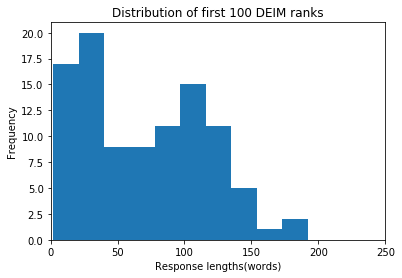

In [28]:
plt.hist([len(i) for i in sep1]);
plt.title('Distribution of first 100 DEIM ranks');
plt.ylabel('Frequency');
plt.xlabel('Response lengths(words)');
plt.xlim(0, 250);

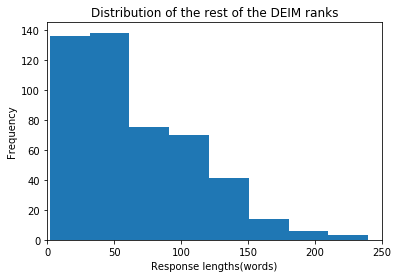

In [29]:
plt.hist([len(i) for i in sep2]);
plt.title('Distribution of the rest of the DEIM ranks');
plt.ylabel('Frequency');
plt.xlabel('Response lengths(words)');
plt.xlim(0, 250);

In [30]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Response Length against DEIM index')

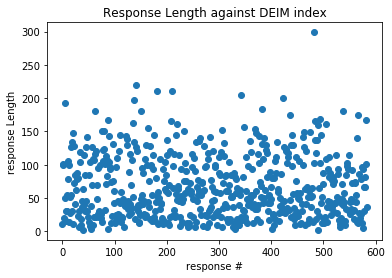

In [31]:
plt.plot([len(i) for i in sep], 'o')
plt.xlabel('response #')
plt.ylabel('response Length')
plt.title('Response Length against DEIM index')

In [32]:
lengths = [len(i) for i in sep]
tempsum = 0
av = []
for i in range(0, len(lengths)):
    if i % 5 == 0:
        av.append(tempsum / 5)
        tempsum = 0
    tempsum += lengths[i]

Text(0.5, 1.0, 'Response Length against DEIM index')

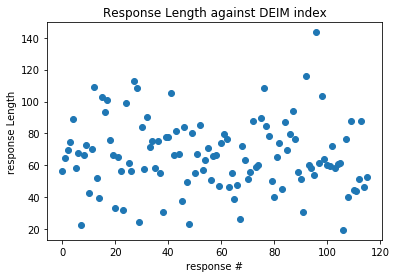

In [33]:
plt.plot(av[1:], 'o')
plt.xlabel('response #')
plt.ylabel('response Length')
plt.title('Response Length against DEIM index')

Text(0.5, 1.0, 'Response Length against DEIM index')

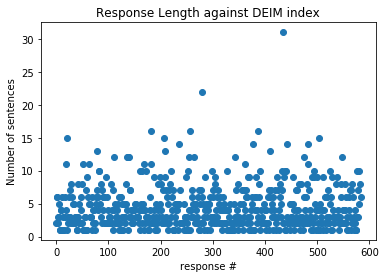

In [34]:
sentence = [i.split('.') for i in ordered_responses]
plt.plot([len(i) for i in sentence], 'o')
plt.xlabel('response #')
plt.ylabel('Number of sentences')
plt.title('Response Length against DEIM index')

### One last experiment with black surveys

## Not Taking out any of the duplicates

In [35]:
response_idx = []
for i in rankings:
    temp = split_responses.loc[i][1]
    response_idx.append(temp)
full_order = [no_unclear[i] for i in response_idx]

Text(0.5, 1.0, 'Response Length against DEIM index')

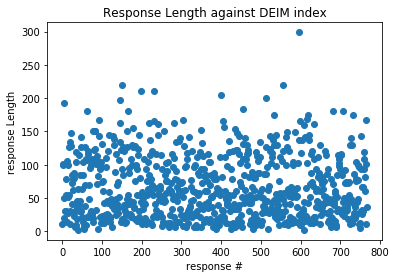

In [36]:
sep = [i.split(' ') for i in full_order]
plt.plot([len(i) for i in sep], 'o')
plt.xlabel('response #')
plt.ylabel('response Length')
plt.title('Response Length against DEIM index')

In [37]:
lengths = [len(i) for i in sep]
tempsum = 0
av = []
for i in range(0, len(lengths)):
    if i % 5 == 0:
        av.append(tempsum / 5)
        tempsum = 0
    tempsum += lengths[i]

Text(0.5, 1.0, 'Response Length against DEIM index')

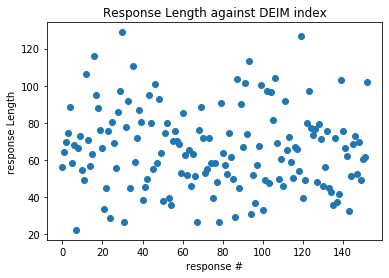

In [38]:
plt.plot(av[1:], 'o')
plt.xlabel('response #')
plt.ylabel('response Length')
plt.title('Response Length against DEIM index')

Text(0.5, 1.0, 'Response Length against DEIM index')

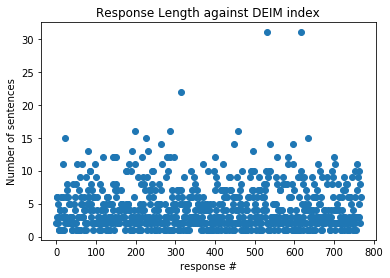

In [39]:
sentence = [i.split('.') for i in full_order]
plt.plot([len(i) for i in sentence], 'o')
plt.xlabel('response #')
plt.ylabel('Number of sentences')
plt.title('Response Length against DEIM index')

## Now the white surveys

In [40]:
white = long_together + long_separate
true = [i for i in white if type(i) != float]
no_u = [i for i in true if '[unclear]' not in i]

In [41]:
white_embed = model.encode(no_u)

In [42]:
my_matrix2 = np.array([list(np.array(i)) for i in white_embed])

In [43]:
np.shape(my_matrix2)

(1193, 768)

In [44]:
rankings2 = DEIM(U2)

NameError: name 'U2' is not defined

### Making the split responses DataFrame

In [45]:
responses = pd.DataFrame({'Responses': no_u})

In [46]:
all_sentences = []
response_numbers = []
idx = 1
for i in responses['Responses']:
    temp = i.split('.')
    for k in temp:
        response_numbers.append(idx)
    for j in temp:
        all_sentences.append(j)
    idx += 1

In [48]:
split_responses = pd.DataFrame({'Individual_sentences': all_sentences, 'Response #': response_numbers, 'Pure_index':
                               range(0, len(all_sentences))})
split_responses

,Individual_sentences,Response #,Pure_index
0,Many of our non-coms[non commissioned officers...,1,0
1,,1,1
2,I would like to take this opportunity to speak...,2,2
3,"They say it is a soldier's privilege to ""bitch""",2,3
4,Since I come in this highly disorganized 45th...,2,4
...,...,...,...
2052,,1191,2052
2053,Men fight better with their own race,1192,2053
2054,,1192,2054
2055,They should be in different outfits so that al...,1193,2055


In [49]:
list_of_sentences = split_responses['Individual_sentences'].to_list()

In [50]:
embed_w = model.encode(list_of_sentences)

In [51]:
my_matrix2 = np.array([list(np.array(i)) for i in embed_w])

In [52]:
np.shape(my_matrix2)

(2057, 768)

In [53]:
U2, S2, Vt2 = linalg.svd(my_matrix2, full_matrices = False)

In [54]:
rankings2 = DEIM(U2)

In [55]:
response_idx2 = []
count = 0
for i in rankings2:
    temp = split_responses.loc[i][1]
    if temp not in response_idx2:
        response_idx2.append(temp)

In [56]:
ordered_responses = [no_u[i-1] for i in response_idx2]

In [57]:
left_out = [i for i in split_responses['Response #'] if i not in response_idx2]

In [58]:
len(left_out)

908

## Plotting some lengths

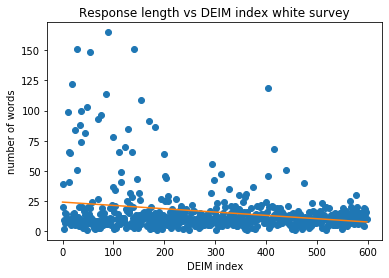

In [59]:
sep = [i.split(' ') for i in ordered_responses]
lengths = [len(i) for i in sep]
plt.plot(lengths, 'o')
plt.title('Response length vs DEIM index white survey')
plt.xlabel('DEIM index')
plt.ylabel('number of words')
y = lengths
x = range(0, len(lengths))
m, b = np. polyfit(x, y, 1)
plt. plot(x, m*x + b)

### Binning the responses

In [60]:
lengths = [len(i) for i in sep]
tempsum = 0
av = []
for i in range(0, len(lengths)):
    if i % 5 == 0:
        av.append(tempsum / 5)
        tempsum = 0
    tempsum += lengths[i]

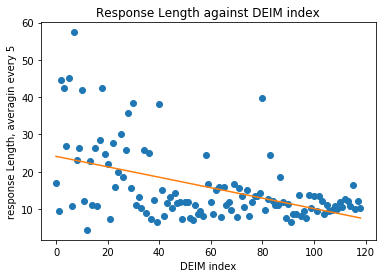

In [61]:
plt.plot(av[1:], 'o')
plt.xlabel('DEIM index')
plt.ylabel('response Length, averagin every 5')
plt.title('Response Length against DEIM index')
y = av[1:]
x = range(0, len(av[1:]))
m, b = np. polyfit(x, y, 1)
plt. plot(x, m*x + b)

## Doingt the same histogram analysis as above

In [62]:
sep3 = [i.split(' ') for i in ordered_responses[:100]]
sep4 = [i.split(' ') for i in ordered_responses[100:]]

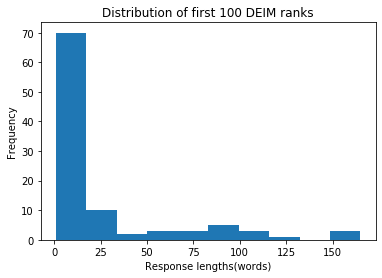

In [65]:
plt.hist([len(i) for i in sep3]);
plt.title('Distribution of first 100 DEIM ranks');
plt.ylabel('Frequency');
plt.xlabel('Response lengths(words)');

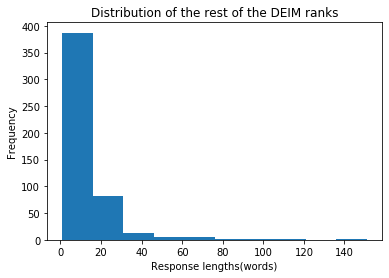

In [66]:
plt.hist([len(i) for i in sep4]);
plt.title('Distribution of the rest of the DEIM ranks');
plt.ylabel('Frequency');
plt.xlabel('Response lengths(words)');